In [1]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**The preprocessing was on local system using the .py file and the train images and masks were converted to train_xx.npy and traing_yy.npy since the storage was not enought on google drive**

In [2]:
import numpy as np
train_xx = np.load('/content/gdrive/MyDrive/task_data/train_xx.npy')
train_yy = np.load('/content/gdrive/MyDrive/task_data/train_yy.npy')


**The images were resized to 256x256 from 1024x1024 becuse the npy files were getting too large (9+9 GB) uing the original size even if we use patchify to break the images into patches**

In [3]:
print(train_xx.shape)
print(train_yy.shape)

(6226, 256, 256, 3)
(6226, 256, 256, 1)


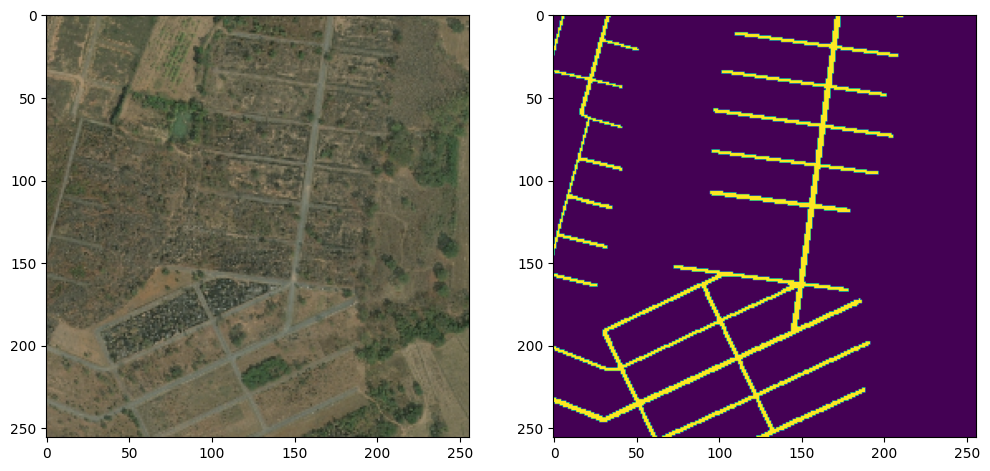

In [4]:
import random
import matplotlib.pyplot as plt
image_number = random.randint(0, len(train_xx))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_xx[image_number])
plt.subplot(122)
plt.imshow(train_yy[image_number][:,:,0])
plt.show()

In [5]:
n_classes = 2
from keras.utils import to_categorical
labels_cat = to_categorical(train_yy, num_classes=n_classes)
print(labels_cat.shape)

(6226, 256, 256, 2)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_xx, labels_cat, test_size = 0.10, random_state = 21)

In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 887.0 kB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


In [ ]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [ ]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [ ]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
==================================================================================================
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv0 (Conv2D)              (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 bn0 (BatchNormalization)    (None, None, None, 64)       256       ['conv0[0][0]']               
                                                                                                  
 relu0 (Activation)          (None, None, None, 64)       0         ['bn0[0][0]']                 
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, None, None, 64)       0         ['relu0[0][0]']               
 ing2D)                                                                                           
                                                                                                  
 pooling0 (MaxPooling2D)     (None, None, None, 64)       0         ['zero_padding2d_1[0][0]']    
                                                                                                  
 stage1_unit1_bn1 (BatchNor  (None, None, None, 64)       256       ['pooling0[0][0]']            
 malization)                                                                                      
                                                                                                  
 stage1_unit1_relu1 (Activa  (None, None, None, 64)       0         ['stage1_unit1_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit1_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit1_conv1 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_2[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit1_bn2 (BatchNor  (None, None, None, 64)       256       ['stage1_unit1_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_unit1_relu2 (Activa  (None, None, None, 64)       0         ['stage1_unit1_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit1_relu2[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit1_conv2 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_3[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit1_sc (Conv2D)    (None, None, None, 64)       4096      ['stage1_unit1_relu1[0][0]']  
                                                                                                  
 add (Add)                   (None, None, None, 64)       0         ['stage1_unit1_conv2[0][0]',  
                                                                     'stage1_unit1_sc[0][0]']     
                                                                                                  
 stage1_unit2_bn1 (BatchNor  (None, None, None, 64)       256       ['add[0][0]']                 
 malization)                                                                                      
                                                                                                  
 stage1_unit2_relu1 (Activa  (None, None, None, 64)       0         ['stage1_unit2_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit2_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit2_conv1 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_4[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit2_bn2 (BatchNor  (None, None, None, 64)       256       ['stage1_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_unit2_relu2 (Activa  (None, None, None, 64)       0         ['stage1_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_5 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit2_relu2[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit2_conv2 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_5[0][0]']    
 )                                                                                                
                                                                                                  
 add_1 (Add)                 (None, None, None, 64)       0         ['stage1_unit2_conv2[0][0]',  
                                                                     'add[0][0]']                 
                                                                                                  
 stage1_unit3_bn1 (BatchNor  (None, None, None, 64)       256       ['add_1[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage1_unit3_relu1 (Activa  (None, None, None, 64)       0         ['stage1_unit3_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit3_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit3_conv1 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_6[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit3_bn2 (BatchNor  (None, None, None, 64)       256       ['stage1_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_unit3_relu2 (Activa  (None, None, None, 64)       0         ['stage1_unit3_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_7 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit3_relu2[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit3_conv2 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_7[0][0]']    
 )                                                                                                
                                                                                                  
 add_2 (Add)                 (None, None, None, 64)       0         ['stage1_unit3_conv2[0][0]',  
                                                                     'add_1[0][0]']               
                                                                                                  
 stage2_unit1_bn1 (BatchNor  (None, None, None, 64)       256       ['add_2[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage2_unit1_relu1 (Activa  (None, None, None, 64)       0         ['stage2_unit1_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, None, None, 64)       0         ['stage2_unit1_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage2_unit1_conv1 (Conv2D  (None, None, None, 128)      73728     ['zero_padding2d_8[0][0]']    
 )                                                                                                
                                                                                                  
 stage2_unit1_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit1_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_unit1_relu2 (Activa  (None, None, None, 128)      0         ['stage2_unit1_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_9 (ZeroPadd  (None, None, None, 128)      0         ['stage2_unit1_relu2[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage2_unit1_conv2 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_9[0][0]']    
 )                                                                                                
                                                                                                  
 stage2_unit1_sc (Conv2D)    (None, None, None, 128)      8192      ['stage2_unit1_relu1[0][0]']  
                                                                                                  
 add_3 (Add)                 (None, None, None, 128)      0         ['stage2_unit1_conv2[0][0]',  
                                                                     'stage2_unit1_sc[0][0]']     
                                                                                                  
 stage2_unit2_bn1 (BatchNor  (None, None, None, 128)      512       ['add_3[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage2_unit2_relu1 (Activa  (None, None, None, 128)      0         ['stage2_unit2_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit2_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit2_conv1 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_10[0][0]']   
 )                                                                                                
                                                                                                  
 stage2_unit2_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_unit2_relu2 (Activa  (None, None, None, 128)      0         ['stage2_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_11 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit2_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit2_conv2 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_11[0][0]']   
 )                                                                                                
                                                                                                  
 add_4 (Add)                 (None, None, None, 128)      0         ['stage2_unit2_conv2[0][0]',  
                                                                     'add_3[0][0]']               
                                                                                                  
 stage2_unit3_bn1 (BatchNor  (None, None, None, 128)      512       ['add_4[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage2_unit3_relu1 (Activa  (None, None, None, 128)      0         ['stage2_unit3_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit3_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit3_conv1 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_12[0][0]']   
 )                                                                                                
                                                                                                  
 stage2_unit3_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_unit3_relu2 (Activa  (None, None, None, 128)      0         ['stage2_unit3_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_13 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit3_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit3_conv2 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_13[0][0]']   
 )                                                                                                
                                                                                                  
 add_5 (Add)                 (None, None, None, 128)      0         ['stage2_unit3_conv2[0][0]',  
                                                                     'add_4[0][0]']               
                                                                                                  
 stage2_unit4_bn1 (BatchNor  (None, None, None, 128)      512       ['add_5[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage2_unit4_relu1 (Activa  (None, None, None, 128)      0         ['stage2_unit4_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_14 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit4_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit4_conv1 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_14[0][0]']   
 )                                                                                                
                                                                                                  
 stage2_unit4_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit4_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_unit4_relu2 (Activa  (None, None, None, 128)      0         ['stage2_unit4_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_15 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit4_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit4_conv2 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_15[0][0]']   
 )                                                                                                
                                                                                                  
 add_6 (Add)                 (None, None, None, 128)      0         ['stage2_unit4_conv2[0][0]',  
                                                                     'add_5[0][0]']               
                                                                                                  
 stage3_unit1_bn1 (BatchNor  (None, None, None, 128)      512       ['add_6[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage3_unit1_relu1 (Activa  (None, None, None, 128)      0         ['stage3_unit1_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_16 (ZeroPad  (None, None, None, 128)      0         ['stage3_unit1_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit1_conv1 (Conv2D  (None, None, None, 256)      294912    ['zero_padding2d_16[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit1_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit1_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit1_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit1_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_17 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit1_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit1_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_17[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit1_sc (Conv2D)    (None, None, None, 256)      32768     ['stage3_unit1_relu1[0][0]']  
                                                                                                  
 add_7 (Add)                 (None, None, None, 256)      0         ['stage3_unit1_conv2[0][0]',  
                                                                     'stage3_unit1_sc[0][0]']     
                                                                                                  
 stage3_unit2_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_7[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage3_unit2_relu1 (Activa  (None, None, None, 256)      0         ['stage3_unit2_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit2_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit2_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_18[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit2_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit2_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_19 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit2_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit2_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_19[0][0]']   
 )                                                                                                
                                                                                                  
 add_8 (Add)                 (None, None, None, 256)      0         ['stage3_unit2_conv2[0][0]',  
                                                                     'add_7[0][0]']               
                                                                                                  
 stage3_unit3_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_8[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage3_unit3_relu1 (Activa  (None, None, None, 256)      0         ['stage3_unit3_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_20 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit3_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit3_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_20[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit3_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit3_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit3_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_21 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit3_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit3_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_21[0][0]']   
 )                                                                                                
                                                                                                  
 add_9 (Add)                 (None, None, None, 256)      0         ['stage3_unit3_conv2[0][0]',  
                                                                     'add_8[0][0]']               
                                                                                                  
 stage3_unit4_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_9[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage3_unit4_relu1 (Activa  (None, None, None, 256)      0         ['stage3_unit4_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_22 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit4_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit4_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_22[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit4_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit4_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit4_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit4_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_23 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit4_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit4_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_23[0][0]']   
 )                                                                                                
                                                                                                  
 add_10 (Add)                (None, None, None, 256)      0         ['stage3_unit4_conv2[0][0]',  
                                                                     'add_9[0][0]']               
                                                                                                  
 stage3_unit5_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_10[0][0]']              
 malization)                                                                                      
                                                                                                  
 stage3_unit5_relu1 (Activa  (None, None, None, 256)      0         ['stage3_unit5_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_24 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit5_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit5_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_24[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit5_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit5_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit5_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit5_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_25 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit5_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit5_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_25[0][0]']   
 )                                                                                                
                                                                                                  
 add_11 (Add)                (None, None, None, 256)      0         ['stage3_unit5_conv2[0][0]',  
                                                                     'add_10[0][0]']              
                                                                                                  
 stage3_unit6_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_11[0][0]']              
 malization)                                                                                      
                                                                                                  
 stage3_unit6_relu1 (Activa  (None, None, None, 256)      0         ['stage3_unit6_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_26 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit6_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit6_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_26[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit6_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit6_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit6_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit6_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_27 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit6_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit6_conv2 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_27[0][0]']   
 )                                                                                                
                                                                                                  
 add_12 (Add)                (None, None, None, 256)      0         ['stage3_unit6_conv2[0][0]',  
                                                                     'add_11[0][0]']              
                                                                                                  
 stage4_unit1_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_12[0][0]']              
 malization)                                                                                      
                                                                                                  
 stage4_unit1_relu1 (Activa  (None, None, None, 256)      0         ['stage4_unit1_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_28 (ZeroPad  (None, None, None, 256)      0         ['stage4_unit1_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit1_conv1 (Conv2D  (None, None, None, 512)      1179648   ['zero_padding2d_28[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit1_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit1_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit1_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit1_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_29 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit1_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit1_conv2 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_29[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit1_sc (Conv2D)    (None, None, None, 512)      131072    ['stage4_unit1_relu1[0][0]']  
                                                                                                  
 add_13 (Add)                (None, None, None, 512)      0         ['stage4_unit1_conv2[0][0]',  
                                                                     'stage4_unit1_sc[0][0]']     
                                                                                                  
 stage4_unit2_bn1 (BatchNor  (None, None, None, 512)      2048      ['add_13[0][0]']              
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu1 (Activa  (None, None, None, 512)      0         ['stage4_unit2_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_30 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit2_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit2_conv1 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_30[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit2_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_31 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit2_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit2_conv2 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_31[0][0]']   
 )                                                                                                
                                                                                                  
 add_14 (Add)                (None, None, None, 512)      0         ['stage4_unit2_conv2[0][0]',  
                                                                     'add_13[0][0]']              
                                                                                                  
 stage4_unit3_bn1 (BatchNor  (None, None, None, 512)      2048      ['add_14[0][0]']              
 malization)                                                                                      
                                                                                                  
 stage4_unit3_relu1 (Activa  (None, None, None, 512)      0         ['stage4_unit3_bn1[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_32 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit3_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit3_conv1 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_32[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit3_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit3_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit3_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_33 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit3_relu2[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage4_unit3_conv2 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_33[0][0]']   
 )                                                                                                
                                                                                                  
 add_15 (Add)                (None, None, None, 512)      0         ['stage4_unit3_conv2[0][0]',  
                                                                     'add_14[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)    (None, None, None, 512)      2048      ['add_15[0][0]']              
                                                                                                  
 relu1 (Activation)          (None, None, None, 512)      0         ['bn1[0][0]']                 
                                                                                                  
 decoder_stage0_upsampling   (None, None, None, 512)      0         ['relu1[0][0]']               
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage0_concat (Con  (None, None, None, 768)      0         ['decoder_stage0_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'stage4_unit1_relu1[0][0]']  
                                                                                                  
 decoder_stage0a_conv (Conv  (None, None, None, 256)      1769472   ['decoder_stage0_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage0a_bn (BatchN  (None, None, None, 256)      1024      ['decoder_stage0a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage0a_relu (Acti  (None, None, None, 256)      0         ['decoder_stage0a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage0b_conv (Conv  (None, None, None, 256)      589824    ['decoder_stage0a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage0b_bn (BatchN  (None, None, None, 256)      1024      ['decoder_stage0b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage0b_relu (Acti  (None, None, None, 256)      0         ['decoder_stage0b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1_upsampling   (None, None, None, 256)      0         ['decoder_stage0b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage1_concat (Con  (None, None, None, 384)      0         ['decoder_stage1_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'stage3_unit1_relu1[0][0]']  
                                                                                                  
 decoder_stage1a_conv (Conv  (None, None, None, 128)      442368    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage1a_bn (BatchN  (None, None, None, 128)      512       ['decoder_stage1a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1a_relu (Acti  (None, None, None, 128)      0         ['decoder_stage1a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1b_conv (Conv  (None, None, None, 128)      147456    ['decoder_stage1a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage1b_bn (BatchN  (None, None, None, 128)      512       ['decoder_stage1b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1b_relu (Acti  (None, None, None, 128)      0         ['decoder_stage1b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage2_upsampling   (None, None, None, 128)      0         ['decoder_stage1b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage2_concat (Con  (None, None, None, 192)      0         ['decoder_stage2_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'stage2_unit1_relu1[0][0]']  
                                                                                                  
 decoder_stage2a_conv (Conv  (None, None, None, 64)       110592    ['decoder_stage2_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage2a_bn (BatchN  (None, None, None, 64)       256       ['decoder_stage2a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage2a_relu (Acti  (None, None, None, 64)       0         ['decoder_stage2a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage2b_conv (Conv  (None, None, None, 64)       36864     ['decoder_stage2a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage2b_bn (BatchN  (None, None, None, 64)       256       ['decoder_stage2b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage2b_relu (Acti  (None, None, None, 64)       0         ['decoder_stage2b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage3_upsampling   (None, None, None, 64)       0         ['decoder_stage2b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage3_concat (Con  (None, None, None, 128)      0         ['decoder_stage3_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'relu0[0][0]']               
                                                                                                  
 decoder_stage3a_conv (Conv  (None, None, None, 32)       36864     ['decoder_stage3_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage3a_bn (BatchN  (None, None, None, 32)       128       ['decoder_stage3a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage3a_relu (Acti  (None, None, None, 32)       0         ['decoder_stage3a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage3b_conv (Conv  (None, None, None, 32)       9216      ['decoder_stage3a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage3b_bn (BatchN  (None, None, None, 32)       128       ['decoder_stage3b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage3b_relu (Acti  (None, None, None, 32)       0         ['decoder_stage3b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage4_upsampling   (None, None, None, 32)       0         ['decoder_stage3b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage4a_conv (Conv  (None, None, None, 16)       4608      ['decoder_stage4_upsampling[0]
 2D)                                                                [0]']                         
                                                                                                  
 decoder_stage4a_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4a_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage4b_conv (Conv  (None, None, None, 16)       2304      ['decoder_stage4a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage4b_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4b_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 final_conv (Conv2D)         (None, None, None, 2)        290       ['decoder_stage4b_relu[0][0]']
                                                                                                  
 softmax (Activation)        (None, None, None, 2)        0         ['final_conv[0][0]']          
                                                                                                  
==================================================================================================
Total params: 24456299 (93.29 MB)
Trainable params: 24438949 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)
__________________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint
# Create ModelCheckpoint callback

# Define checkpoint path and filename pattern
checkpoint_path = "/content/gdrive/MyDrive/task_data/checkpoints/model_epoch_{epoch:02d}.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model
    period=3,  # Save every 4 epochs
    verbose=1
)
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          callbacks=[checkpoint_callback],
          validation_data=(X_test_prepr, y_test))

WARNING:tensorflow:`period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
Epoch 1/100
351/351 [==============================] - 954s 3s/step - loss: 0.1375 - accuracy: 0.9519 - val_loss: 0.1262 - val_accuracy: 0.9625
Epoch 2/100
351/351 [==============================] - 933s 3s/step - loss: 0.0853 - accuracy: 0.9687 - val_loss: 0.0845 - val_accuracy: 0.9694
Epoch 3/100
351/351 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9718
Epoch 3: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_03.h5
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
351/351 [==============================] - 936s 3s/step - loss: 0.0751 - accuracy: 0.9718 - val_loss: 0.0767 - val_accuracy: 0.9712
Epoch 4/100
351/351 [==============================] - 927s 3s/step - loss: 0.0712 - accuracy: 0.9730 - val_loss: 0.0866 - val_accuracy: 0.9702
Epoch 5/100
351/351 [==============================] - 929s 3s/step - loss: 0.0668 - accuracy: 0.9744 - val_loss: 0.0693 - val_accuracy: 0.9734
Epoch 6/100
351/351 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9752
Epoch 6: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_06.h5
351/351 [==============================] - 929s 3s/step - loss: 0.0643 - accuracy: 0.9752 - val_loss: 0.0683 - val_accuracy: 0.9744
Epoch 7/100
351/351 [==============================] - 926s 3s/step - loss: 0.0606 - accuracy: 0.9764 - val_loss: 0.0673 - val_accuracy: 0.9744
Epoch 8/100
351/351 [==============================] - 927s 3s/step - loss: 0.0613 - accuracy: 0.9762 - val_loss: 0.0683 - val_accuracy: 0.9742
Epoch 9/100
351/351 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9777
Epoch 9: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_09.h5
351/351 [==============================] - 928s 3s/step - loss: 0.0570 - accuracy: 0.9777 - val_loss: 0.0669 - val_accuracy: 0.9751
Epoch 10/100
351/351 [==============================] - 926s 3s/step - loss: 0.0539 - accuracy: 0.9787 - val_loss: 0.0675 - val_accuracy: 0.9742
Epoch 11/100
351/351 [==============================] - 927s 3s/step - loss: 0.0557 - accuracy: 0.9781 - val_loss: 0.0658 - val_accuracy: 0.9756
Epoch 12/100
351/351 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9798
Epoch 12: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_12.h5
351/351 [==============================] - 928s 3s/step - loss: 0.0506 - accuracy: 0.9798 - val_loss: 0.0651 - val_accuracy: 0.9758
Epoch 13/100
351/351 [==============================] - 925s 3s/step - loss: 0.0520 - accuracy: 0.9794 - val_loss: 0.0653 - val_accuracy: 0.9757
Epoch 14/100
292/351 [=======================>......] - ETA: 2:33 - loss: 0.0489 - accuracy: 0.9804

In [ ]:
import segmentation_models as sm
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# Define the backbone and preprocessing function
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess the input data
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

**The model was trained multiple times with the checkpoint loaded from previous training , the RAM and GPU were not enough to start the training  hence TPU was used which could train only 12 epochs and then I have to switch to different account with the stored checkpoint to continue the training**

In [ ]:
# Load the model from the checkpoint of epoch 12
checkpoint_path = "/content/gdrive/MyDrive/task_data/model_epoch_12.h5"
model_resnet_backbone = load_model(checkpoint_path, custom_objects={'categorical_crossentropy': sm.losses.categorical_focal_loss})

# Compile the model
metrics = ['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
# Create ModelCheckpoint callback for saving new checkpoints
checkpoint_path = "/content/gdrive/MyDrive/task_data/checkpoints/model_epoch_{epoch:02d}.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model
    period=3,  # Save every 3 epochs
    verbose=1
)

# Continue training the model
history = model_resnet_backbone.fit(
    X_train_prepr,
    y_train,
    batch_size=16,
    epochs=100,  # Continue training for 100 more epochs
    verbose=1,
    callbacks=[checkpoint_callback],
    validation_data=(X_test_prepr, y_test)
)

Epoch 1/100
351/351 [==============================] - 993s 3s/step - loss: 0.0510 - accuracy: 0.9797 - val_loss: 0.0669 - val_accuracy: 0.9754
Epoch 2/100
351/351 [==============================] - 959s 3s/step - loss: 0.0498 - accuracy: 0.9801 - val_loss: 0.0663 - val_accuracy: 0.9753
Epoch 3/100
351/351 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9812
Epoch 3: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_03.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/351 [==============================] - 969s 3s/step - loss: 0.0465 - accuracy: 0.9812 - val_loss: 0.0700 - val_accuracy: 0.9758
Epoch 4/100
351/351 [==============================] - 965s 3s/step - loss: 0.0452 - accuracy: 0.9817 - val_loss: 0.0683 - val_accuracy: 0.9763
Epoch 5/100
351/351 [==============================] - 964s 3s/step - loss: 0.0432 - accuracy: 0.9824 - val_loss: 0.0646 - val_accuracy: 0.9759
Epoch 6/100
351/351 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9828
Epoch 6: saving model to /content/gdrive/MyDrive/task_data/checkpoints/model_epoch_06.h5
351/351 [==============================] - 964s 3s/step - loss: 0.0422 - accuracy: 0.9828 - val_loss: 0.0711 - val_accuracy: 0.9760
Epoch 7/100
351/351 [==============================] - 964s 3s/step - loss: 0.0406 - accuracy: 0.9833 - val_loss: 0.0705 - val_accuracy: 0.9753
Epoch 8/100
351/351 [==============================] - 958s 3s/step - loss: 0.0406 - accuracy: 0.9834 - val_loss: 0.06

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_xx, train_yy, test_size = 0.10, random_state = 21)

**Final model trained on 24 epoch (12+12) using checkpoints**

In [7]:
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
# Path to the checkpoint file (you should replace this with the actual path)
checkpoint_path = '/content/gdrive/MyDrive/task_data/checkpoints/model_epoch_12.h5'

# Load the saved model
model = load_model(checkpoint_path)

# prediction of the output
pred_test = model.predict(X_test)


# To visualize or further process predictions, you can use predictions variable


20/20 [==============================] - 218s 11s/step


In [8]:
y_pred_argmax=np.argmax(pred_test, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [15]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number,:,:,0]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 302ms/step


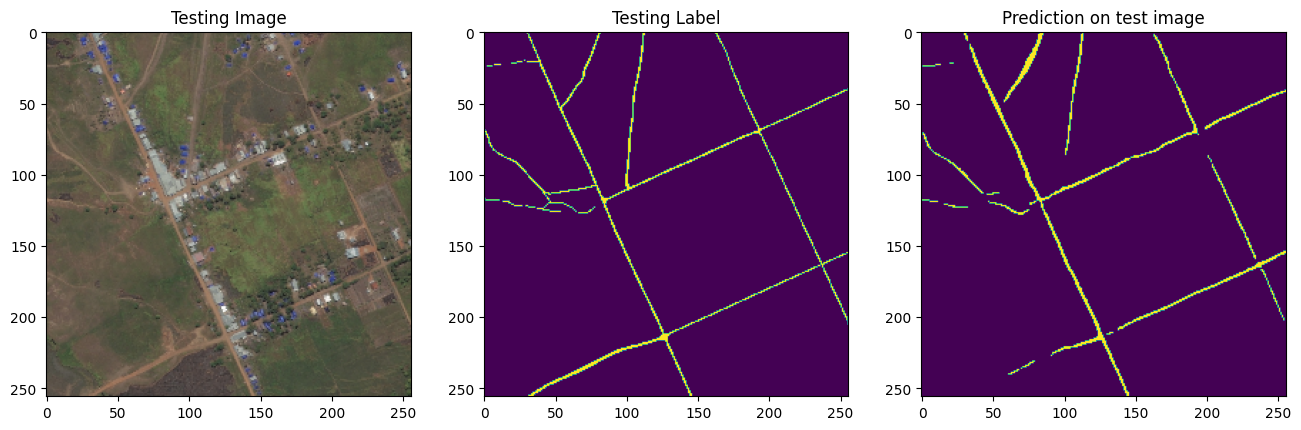

In [16]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

**Conclusion: The training and validationa accuracy reached 98.5 and 97.7% respectively, if we continue thraining it will increase more but due to Ram requirements i can only train for 3 hr per day on one colab (on TPU)**